In [1]:
import numpy as np
import scipy as sp

import h5py
import natsort
from scipy.ndimage import gaussian_filter

import matplotlib.pyplot as plt
from functools import partial

from jax import jit

import jax
import jax.numpy as jnp
import time 
import jax.scipy.optimize

# this is the package to solve the lippman-Schwinger equation
import jax_fd
import near_field

In [2]:
# size of the domain in x and y
ax = 1.0
ay = 1.0

# number of discretization points per dimension
nxi = 80
nyi = nxi

# PML
npml = 20
sigmaMax = 80

nx = nxi + 2*npml
ny = nx

# we choose to have 4 points per wavelenght
#omega = 2*jnp.pi*nyi/10;
omega = 2*jnp.pi*2.5
order = 2

# grid spacing
hx = 1/(nxi-1)

sampling_radius = 1.0
n_angles = nxi


In [3]:
# initialize the parameters
params_nf = near_field.init_params_near_field(ax, ay, nxi, nyi,npml,\
                                         sampling_radius,\
                                         n_angles, omega, sigmaMax)

In [4]:
# definition of the perturbation by the lense
def perturbation(x,y):
    return (0.2*sp.stats.norm.pdf(x,0.1,5*hx)*sp.stats.norm.pdf(y,0.1,5*hx))
    #return    1.0*np.exp(-50*(np.square(x-0.1) + np.square(y-0.1)))\
            #+ 1.0*np.exp(-500*(np.square(x-0.1) + np.square(y-0.1)))\
            #+ 1.0*np.exp(-500*(np.square(x-0.15) + np.square(y+0.3)))

# we sample the perturbation
eta = perturbation(params_nf.fd_params.Xi, params_nf.fd_params.Yi) 
m = 1 + eta
eta_vect = np.reshape(eta, (-1,))
m_vect = np.reshape(m, (-1,))

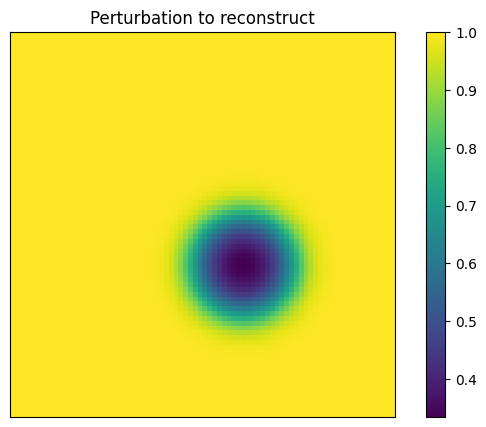

In [5]:
plt.figure(figsize=(8,5))
plt.imshow(1/jnp.sqrt(m_vect).reshape((nxi,nyi)))
plt.xticks([]); plt.yticks([]);
plt.title('Perturbation to reconstruct', color='black')
plt.colorbar()
plt.show()

In [6]:
eta_ext = near_field.ExtendModel(eta, nxi, nyi, npml)
m_ext = near_field.ExtendModel(m, nxi, nyi, npml)

In [7]:
near_field_ = near_field.NearField(omega, params_nf, m_ext, order)
near_field_jit = jit(near_field_)

In [8]:
field = near_field_()(eta_ext)

In [13]:
field_jit = near_field_jit(eta_ext)

TypeError: unhashable type: 'ArrayImpl'

In [9]:
Lambda = near_field.smoothing_solution(field[0].T, params_nf, n_angles, sampling_radius)

In [10]:
field[0].shape

(80, 14400)

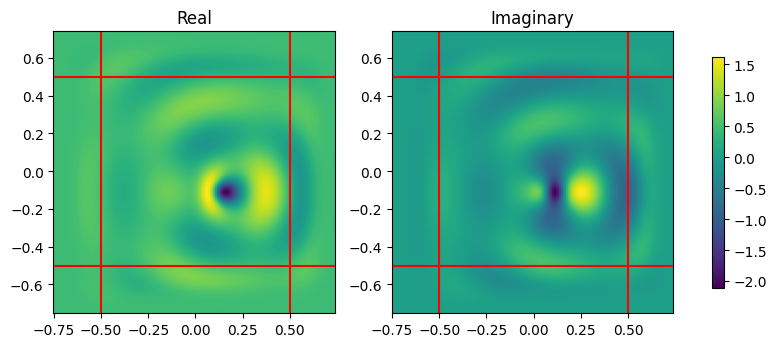

In [11]:
near_field.DisplayField(field[0].T[:,0],params_nf.fd_params.x,params_nf.fd_params.y, npml)

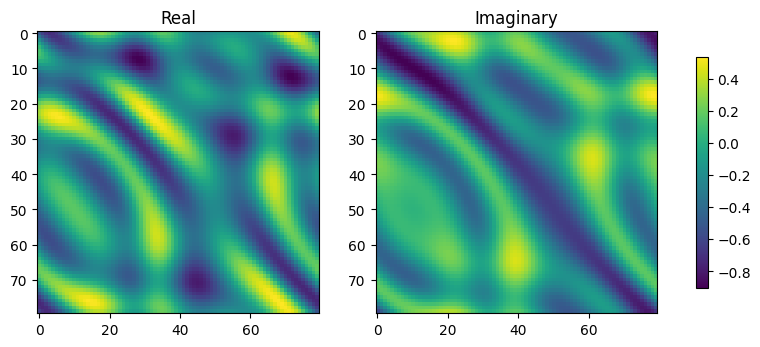

In [12]:
near_field.DisplayField(Lambda, params_nf.fd_params.xi,params_nf.fd_params.yi)

In [14]:
#near_field.DisplayField(Lambda_pred[1], params_nf.fd_params.xi,params_nf.fd_params.yi)

In [70]:
Lambda.shape

(80, 80)

In [14]:
eta_0 = 0*eta_vect

In [22]:
#opt_eta = sp.optimize.minimize(near_field.misfit, eta_0, args=(params_nf, projection_mat, Lambda, order), method='BFGS', jac=True, options={'disp': True, 'maxiter': 100})

In [23]:
#f, grad_f = near_field.misfit(eta_0, params_nf, projection_mat, Lambda, order)